#  Analyse spectra holo at AuxTel for Configurations


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : September 22th  2022
- last update : October 11th 2022


- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

/opt/conda/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

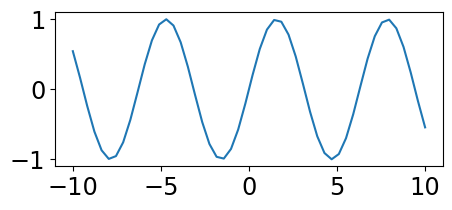

In [3]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [4]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [5]:
from datetime import datetime,date

In [6]:
#pip install fpdf
#from fpdf import FPDF

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [8]:
string_date

'2022-10-13'

In [9]:
from iminuit import Minuit
import iminuit

In [10]:
iminuit.__version__

'2.8.4'

In [11]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor,dumpParameters,dumpfitparameters
from spectractor.extractor.spectrum import Spectrum, detect_lines, calibrate_spectrum
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, HGAMMA, HDELTA ,O2_1, O2_2, O2B,H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [12]:
from time import sleep

In [13]:
from astropy.time import Time
import astropy.units as u

In [14]:
import pickle

# Calibration line

In [15]:
ATMOSPHERIC_LINES_CALIB = [O2B,O2_1, O2_2]
HYDROGEN_LINES_CALIB = [HALPHA, HBETA, HGAMMA, HDELTA]

setatml = set(ATMOSPHERIC_LINES_CALIB)
sethdryl = set(HYDROGEN_LINES_CALIB )

LINES_CALIB = list(sethdryl.union(setatml))

lines_calib = Lines(LINES_CALIB , hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)

# Function

In [16]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^exposure_.*([0-9][0-9][0-9][0-9][0-9])_postisrccd.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None


In [17]:
def subdir_tag_forsorting(subdir):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('.*([0-9][0-9][0-9][0-9][0-9])$', subdir)
    if len(m)>0:
        return m[0]
    else:
        return None


In [18]:
file_tag_forsorting('exposure_2022031600330_postisrccd.fits')

'00330'

In [19]:
subdir_tag_forsorting('2022031600330')

'00330'

# Config

In [20]:
# path index for each month
DATE="20220630"
#DATE="20211104"
#filterdispersername = "empty~holo4_003"
filterdispersername = "BG40~holo4_003"
#filterdispersername = "FELH0600~holo4_003"
imagemode = "postISRCCD"
#imagemode = "unflattened"
FLAG_RECALIB = False

In [21]:
version="v5.0"

In [22]:
# Choose the config filename
list_of_spectractorconfigfiles= ['auxtel_config_holo_DECONVOLUTION_PSF1D.ini' ,
                                 'auxtel_config_holo_DECONVOLUTION_PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DFFM300650.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotA.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotB.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotC.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotD.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF1D_BG40.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF1DTRUNC.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF2DTRUNC.ini']
config_idx = 3
                                
configfilename= os.path.join("./config",list_of_spectractorconfigfiles[config_idx])
#configdir = (list_of_spectractorconfigfiles[config_idx].split("_")[-1]).split(".") [0]
configdir = "config_" + (list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_")[-1]).split(".") [0]

In [23]:
configdir 

'config_DECONVOLUTION_PSF2DFFM'

In [24]:
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini


In [25]:
load_config(configfilename)

No rebinning: parameters.REBIN is forced to 1.


In [26]:
configmode = list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_DECONVOLUTION_")[-1].split(".") [0]
configmode

'PSF2DFFM'

## Parameters

In [27]:
dumpParameters()

ASTROMETRYNET_DIR 
BGD_ORDER 1
CALIB_BGD_NPARAMS 4
CALIB_BGD_ORDER 3
CALIB_BGD_WIDTH 15
CALIB_PEAK_WIDTH 7
CALIB_SAVGOL_ORDER 2
CALIB_SAVGOL_WINDOW 5
CCD_ARCSEC2RADIANS 4.84813681109536e-06
CCD_GAIN 1.1
CCD_IMSIZE 4096
CCD_MAXADU 170000
CCD_PIXEL2ARCSEC 0.0952
CCD_PIXEL2MM 0.01
CCD_REBIN 1
CONFIG_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/../config/
DEBUG False
DEBUG_LOGGING False
DISPERSER_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/
DISPLAY False
DISTANCE2CCD 175
DISTANCE2CCD_ERR 0.75
FGB37 {'label': 'FGB37', 'min': 350, 'max': 750}
FILTERS [{'label': 'RG715', 'min': 690, 'max': 1100}, {'label': 'FGB37', 'min': 350, 'max': 750}, {'label': 'Halfa', 'min': 0.0006431, 'max': 0.0006686999999999999}, {'label': 'Z-Gunn', 'min': 800, 'max': 1100}]
FLAM_TO_ADURATE 5175865186660.421
GRATING_ORDER_2OVER1 0.1
GROOVES_PER_MM 350
HAL

# Path

In [28]:
HOSTCC=True
LAPTOP=False

In [29]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
    if configdir == "":
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
    else:
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
        path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
        path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
        path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)

else:
    if not LAPTOP:
        path_auxtel="/Users/sylvie/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/sylvie/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
    else:
        path_auxtel="/Users/dagoret/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/dagoret/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
        


In [30]:
path_output_spectractor

'/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630'

In [31]:
! ls -l $path_output_spectractor

total 0
drwxrws--- 1 dagoret lsst 2 Oct 13 02:56 2022063000078
drwxrws--- 1 dagoret lsst 2 Oct 12 22:52 2022063000079
drwxrws--- 1 dagoret lsst 2 Oct 12 22:54 2022063000093
drwxrws--- 1 dagoret lsst 2 Oct 12 20:04 2022063000094
drwxrws--- 1 dagoret lsst 2 Oct 12 22:41 2022063000108
drwxrws--- 1 dagoret lsst 2 Oct 13 03:09 2022063000123
drwxrws--- 1 dagoret lsst 2 Oct 12 20:34 2022063000138
drwxrws--- 1 dagoret lsst 2 Oct 13 06:32 2022063000160
drwxrws--- 1 dagoret lsst 2 Oct 13 07:22 2022063000219
drwxrws--- 1 dagoret lsst 2 Oct 12 20:41 2022063000234
drwxrws--- 1 dagoret lsst 2 Oct 13 00:28 2022063000248
drwxrws--- 1 dagoret lsst 2 Oct 13 04:39 2022063000263
drwxrws--- 1 dagoret lsst 2 Oct 13 01:21 2022063000278
drwxrws--- 1 dagoret lsst 2 Oct 13 00:55 2022063000279
drwxrws--- 1 dagoret lsst 2 Oct 13 00:43 2022063000319
drwxrws--- 1 dagoret lsst 2 Oct 12 22:35 2022063000320
drwxrws--- 1 dagoret lsst 2 Oct 12 23:10 2022063000340
drwxrws--- 1 dagoret lsst 2 Oct 12 18:40 2022063000355
dr

In [32]:
# standard configuration for spectractor
#config = os.path.join(path_spectractor_config,"auxtel.ini")
#config=os.path.join("./config",configfilename)
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini


In [33]:
load_config(configfilename)

No rebinning: parameters.REBIN is forced to 1.


## Logbook for file selection

In [34]:
filename_logbook='logbooks/auxtellogbook_'+filterdispersername+"_"+DATE+'_' + version+'.csv'

In [35]:
df=pd.read_csv(filename_logbook,index_col=0)

In [36]:
pd.set_option('display.max_rows', None)

In [37]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2022-06-30T23:37:19.755,/sps/lsst/groups/auxtel/data/2022/BG40~holo4_0...,exposure_2022063000078_postisrccd.fits,78,HD185975,BG40,holo4_003,2.023848,30.0,...,7.1,21.0,4.6,NaN,NaN,NaN,NaN,,NaN,NaN
1,1,2022-06-30T23:38:02.841,/sps/lsst/groups/auxtel/data/2022/BG40~holo4_0...,exposure_2022063000079_postisrccd.fits,79,HD185975,BG40,holo4_003,2.023378,30.0,...,7.1,21.0,4.6,NaN,NaN,NaN,NaN,,NaN,NaN
2,2,2022-06-30T23:48:21.242,/sps/lsst/groups/auxtel/data/2022/BG40~holo4_0...,exposure_2022063000093_postisrccd.fits,93,HD142331,BG40,holo4_003,1.269733,30.0,...,7.0,22.0,5.4,NaN,NaN,NaN,NaN,,NaN,NaN
3,3,2022-06-30T23:49:04.154,/sps/lsst/groups/auxtel/data/2022/BG40~holo4_0...,exposure_2022063000094_postisrccd.fits,94,HD142331,BG40,holo4_003,1.267367,30.0,...,7.0,22.0,5.4,NaN,NaN,NaN,NaN,,NaN,NaN
4,4,2022-06-30T23:58:14.849,/sps/lsst/groups/auxtel/data/2022/BG40~holo4_0...,exposure_2022063000108_postisrccd.fits,108,HD142331,BG40,holo4_003,1.238663,30.0,...,6.7,22.0,6.6,NaN,NaN,NaN,NaN,,NaN,NaN
5,5,2022-06-30T23:58:57.759,/sps/lsst/groups/auxtel/data/2022/BG40~holo4_0...,exposure_2022063000109_postisrccd.fits,109,HD142331,BG40,holo4_003,1.236559,30.0,...,6.7,22.0,6.6,NaN,NaN,NaN,NaN,,NaN,NaN
6,6,2022-07-01T00:08:05.976,/sps/lsst/groups/auxtel/data/2022/BG40~holo4_0...,exposure_2022063000123_postisrccd.fits,123,HD142331,BG40,holo4_003,1.211177,30.0,...,6.7,22.0,5.8,NaN,NaN,NaN,NaN,,NaN,NaN
7,7,2022-07-01T00:18:01.961,/sps/lsst/groups/auxtel/data/2022/BG40~holo4_0...,exposure_2022063000138_postisrccd.fits,138,HD142331,BG40,holo4_003,1.186654,30.0,...,6.4,23.0,5.4,NaN,NaN,NaN,NaN,,NaN,NaN
8,8,2022-07-01T00:18:44.868,/sps/lsst/groups/auxtel/data/2022/BG40~holo4_0...,exposure_2022063000139_postisrccd.fits,139,HD142331,BG40,holo4_003,1.184997,30.0,...,6.4,23.0,5.8,NaN,NaN,NaN,NaN,,NaN,NaN
9,9,2022-07-01T00:34:57.649,/sps/lsst/groups/auxtel/data/2022/BG40~holo4_0...,exposure_2022063000160_postisrccd.fits,160,HD185975,BG40,holo4_003,1.985135,30.0,...,6.2,23.0,5.6,NaN,NaN,NaN,NaN,,NaN,NaN


## Selection of input files

In [38]:
df_good=df
df_good["quality"] = 1

In [39]:
for spectra_file in df_good["file"]:
    print(spectra_file)

exposure_2022063000078_postisrccd.fits
exposure_2022063000079_postisrccd.fits
exposure_2022063000093_postisrccd.fits
exposure_2022063000094_postisrccd.fits
exposure_2022063000108_postisrccd.fits
exposure_2022063000109_postisrccd.fits
exposure_2022063000123_postisrccd.fits
exposure_2022063000138_postisrccd.fits
exposure_2022063000139_postisrccd.fits
exposure_2022063000160_postisrccd.fits
exposure_2022063000179_postisrccd.fits
exposure_2022063000180_postisrccd.fits
exposure_2022063000219_postisrccd.fits
exposure_2022063000233_postisrccd.fits
exposure_2022063000234_postisrccd.fits
exposure_2022063000248_postisrccd.fits
exposure_2022063000263_postisrccd.fits
exposure_2022063000278_postisrccd.fits
exposure_2022063000279_postisrccd.fits
exposure_2022063000319_postisrccd.fits
exposure_2022063000320_postisrccd.fits
exposure_2022063000339_postisrccd.fits
exposure_2022063000340_postisrccd.fits
exposure_2022063000355_postisrccd.fits
exposure_2022063000369_postisrccd.fits
exposure_2022063000370_po

## Selection of Spectractor output files

In [40]:
# total number of exposures
NBEXP=0
# total number of exposures without dir
NBEXPNODIR=0
# total number of exposures with dir
NBEXPWTHDIR=0
# total number of exposures with plots
NBEXPWTHPLT=0
# total number of exposures with spectra
NBEXPWTHSPEC=0

# list of exposures
LISTNUM=[]
# list of exposure without dir (not run spectraction)
LISTNUMNODIR=[]
# list of exposure with dir (spectraction has been run)
LISTNUMWTHDIR=[]
# list of exposures with plots (Spectractor has run up to some point)
LISTNUMWTHPLOTS=[]
# list of exposures with spectraction output (Spectractor has completed)
LISTNUMWTHSPECTR=[]

# list of selected spectra path
List_of_spectra_path=[]

In [41]:
list_of_files=os.listdir(path_output_spectractor)
list_of_files=sorted(list_of_files)


print("list of subdir found ",list_of_files)

for subdir in list_of_files:
    
    
    #tag = file_tag_forsorting(subdir)
    tag = subdir_tag_forsorting(subdir)
    
        
    print(tag)    
    #if tag is not None and int(tag)<317:
    #    continue
    if tag is None :
        continue
  
    
    
    fulldir=os.path.join(path_output_spectractor,subdir)



    if not os.path.isdir(fulldir):
        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is not a directory".format(subdir))
        

        NBEXPNODIR+=1


    else:

        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is a directory".format(subdir))

        tagname=subdir_tag_forsorting(subdir)
        print("tagname= {}".format(tagname))
        #targetname=file_target(subdir)
        #print("targetname= {}".format(targetname))
        



        NBEXP += 1
        LISTNUM.append(tagname)



        dir_plots=os.path.join(fulldir,"plots")
        dir_spectration = os.path.join(fulldir, "basespec")

        flag_empty1 = True
        flag_empty2 = True


        if os.path.isdir(dir_plots):
            if any(os.scandir(dir_plots)):
                print("dir_plots is not empty")
                NBEXPWTHPLT+=1
                LISTNUMWTHPLOTS.append(tagname)
                flag_empty1 = False

            else:
                print("dir_plots is empty")


        if os.path.isdir(dir_spectration):
            if any(os.scandir(dir_spectration)):
                print("dir_spectration is not empty")
                NBEXPWTHSPEC+=1
                LISTNUMWTHSPECTR.append(tagname)
                flag_empty2 = False
                List_of_spectra_path.append(dir_spectration)

            else:
                print("dir_spectration is empty")

        if flag_empty1 and flag_empty2 :
            NBEXPNODIR+=1
            LISTNUMNODIR.append(tagname)
        else:
            NBEXPWTHDIR += 1
            LISTNUMWTHDIR.append(tagname)



print("-----------------------------------------------------------------")


#LISTNUM=sorted(LISTNUM)
#LISTNUMNODIR=sorted(LISTNUMNODIR)
#LISTNUMWTHDIR=sorted(LISTNUMWTHDIR)
#LISTNUMWTHPLOTS=sorted(LISTNUMWTHPLOTS)
#LISTNUMWTHSPECTR=sorted(LISTNUMWTHSPECTR)
List_of_spectra_path=sorted(List_of_spectra_path)

print("Full list of Exposures : .......................{}".format(LISTNUM))
print("Full list of Exposures without output dir: .....{}".format(LISTNUMNODIR))
print("Full list of Exposures with output dir: ....... {}".format(LISTNUMWTHDIR))
print("Full list of Exposures with output plots: ..... {}".format(LISTNUMWTHPLOTS))
print("Full list of Exposures with output spectra: ....{}".format(LISTNUMWTHSPECTR))




print("Total number of exposures : .....................{}".format(NBEXP))
print("Total number of exposures without dir : .........{}".format(NBEXPNODIR))
print("Total number of exposures with dir :.............{}".format(NBEXPWTHDIR))
print("Total number of exposures with plots : ..........{}".format(NBEXPWTHPLT))
print("Total number of exposures with spectra: .........{}".format(NBEXPWTHSPEC))


list of subdir found  ['2022063000078', '2022063000079', '2022063000093', '2022063000094', '2022063000108', '2022063000123', '2022063000138', '2022063000160', '2022063000219', '2022063000234', '2022063000248', '2022063000263', '2022063000278', '2022063000279', '2022063000319', '2022063000320', '2022063000340', '2022063000355', '2022063000422', '2022063000437', '2022063000452', '2022063000453', '2022063000478', '2022063000479', '2022063000508', '2022063000509', '2022063000524', '2022063000538', '2022063000563', '2022063000564', '2022063000592']
00078
---------------------------------------------
2022063000078  	   00078
2022063000078 is a directory
tagname= 00078
dir_plots is not empty
dir_spectration is not empty
00079
---------------------------------------------
2022063000079  	   00079
2022063000079 is a directory
tagname= 00079
dir_plots is not empty
dir_spectration is not empty
00093
---------------------------------------------
2022063000093  	   00093
2022063000093 is a director

In [42]:
#dir_spectra="outputs_reprocess"
print(List_of_spectra_path)

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000078/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000079/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000093/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000094/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000108/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000123/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000138/basespec'

In [43]:
config

'./config/auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini'

## Extraction of spectra

In [44]:
all_files_spectra = []
all_files_spectrogram = []
all_files_lines = []
all_files_table = []

# loop on topdir
for dir_spectra in List_of_spectra_path:
    for filename in os.listdir(dir_spectra):
        if re.search("_spectrum.fits$",filename):
            the_file_spectrum=os.path.join(dir_spectra,filename)
            all_files_spectra.append(the_file_spectrum)
            the_file_spectrogram=the_file_spectrum.replace("_spectrum","_spectrogram")
            all_files_spectrogram.append(the_file_spectrogram)
            the_file_lines=the_file_spectrum.replace("_spectrum.fits","_lines.csv")
            all_files_lines.append(the_file_lines)
            the_file_table=the_file_spectrum.replace("_spectrum.fits","_table.csv")
            all_files_table.append(the_file_table)
    

In [45]:
all_files_spectra[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000078/basespec/exposure_2022063000078_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000079/basespec/exposure_2022063000079_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000093/basespec/exposure_2022063000093_postisrccd_spectrum.fits']

In [46]:
all_files_spectrogram[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000078/basespec/exposure_2022063000078_postisrccd_spectrogram.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000079/basespec/exposure_2022063000079_postisrccd_spectrogram.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000093/basespec/exposure_2022063000093_postisrccd_spectrogram.fits']

In [47]:
all_files_lines[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000078/basespec/exposure_2022063000078_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000079/basespec/exposure_2022063000079_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000093/basespec/exposure_2022063000093_postisrccd_lines.csv']

In [48]:
all_files_table[:3] 

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000078/basespec/exposure_2022063000078_postisrccd_table.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000079/basespec/exposure_2022063000079_postisrccd_table.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000093/basespec/exposure_2022063000093_postisrccd_table.csv']

## Selection of good spectra

In [49]:
all_good_spectra_spectrum_files = sorted(all_files_spectra)

In [50]:
N=len(all_good_spectra_spectrum_files)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

## One Spectrum

In [51]:
#idx=7 # Big Shift
#idx = 8 # Shift, I don't know why
idx = 9 # OK
#idx = 10 # OK
#idx = 11 # OK
#idx = 12 # 0K
#idx = 13 # strange shift after recalib
#idx = 14 # OK
#idx = 15 # Shift
#idx = 16 # BAD Spectrum Nothing
#idx = 17 # OK
#idx = 18 # trange shift after recalib
#idx = 19 # OK
#idx = 20 # OK
#idx = 21 # OK
#idx = 22 # BAD Spectrum
#idx = 24 # OK


fullfilename = all_good_spectra_spectrum_files[idx]
    
filename = os.path.basename(fullfilename)
print(idx,")",filename," ",fullfilename)
    
    
fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(3, 1, 1)
    
filename= os.path.basename(fullfilename)
tag=file_tag_forsorting(filename.split(".")[0])

    
   
     
s=Spectrum(fullfilename, config=config,fast_load=False)
label=filename.split('.')[0]+" "
label = str(idx) +"):"+label
#s.plot_spectrum(ax=ax1,force_lines=True,label=label)
s.plot_spectrum(ax=ax1,force_lines=True,label=label)

   
if FLAG_RECALIB: 
    parameters.DEBUG=True
    parameters.LIVE_FIT=True
    ax2 = fig.add_subplot(3, 1, 2)
    print(" === RECALIBRATE lines === ")
    s.lines = lines_calib
    newlambdas = calibrate_spectrum(s, with_adr=True)
    label=str(idx) +"):"+filename.split('.')[0]+" recalibrated"
    s.plot_spectrum(ax=ax2,force_lines=True,label=label)
    t=s.lines.print_detected_lines(print_table=True)
    print(t["Shift"])
    print(t["Chisq"])
    
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.plot(newlambdas,s.data,"r-")
    s.lines.plot_detected_lines(ax=ax3)
    s.lines.plot_atomic_lines(ax=ax3,force=True)
    ax3.set_xlim(parameters.LAMBDA_MIN, parameters.LAMBDA_MAX)
    ax3.grid()
    
    

plt.show()
    

9 ) exposure_2022063000234_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000234/basespec/exposure_2022063000234_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T01:31:42.373
set expo to 30.0
set airmass to 1.083963949124453
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2528306053477632
set dec to -8.580388888888889
set hour_angle to -7.934319471575924
set temperature to 5.2
set pressure to 740.15
set humidity to 29.0
set lambda_ref to 576.610419134762
set parallactic_angle to -162.1543258247951


2022-10-13 09:19:33  astropy    _showwarning         WARNING AstropyDeprecationWarning: The update_default_config function is deprecated and may be removed in a future version.
2022-10-13 09:19:36  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


target_name = HD142331, Selected object name for Simbad : HD142331
 MAIN_ID        RA           DEC      ...  Z_VALUE   SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1


In [52]:
parameters.DEBUG=False
parameters.LIVE_FIT=False

## All Spectra

In [53]:
parameters.DISPLAY=True

FLAG_ORDER2 = True

infos = []
all_lambdas=[]
all_data=[]
all_data_err=[]

if FLAG_ORDER2:
    all_lambdas_order2=[]
    all_data_order2=[]
    all_data_err_order2=[]

all_num=[]
all_figs = []


idx=0
for fullfilename in all_good_spectra_spectrum_files:
    
    filename = os.path.basename(fullfilename)
    print("============================",idx,")",filename," ",fullfilename,"==============================")
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    
    filename= os.path.basename(fullfilename)
    tag=file_tag_forsorting(filename.split(".")[0])
    all_num.append(tag)
    
   
     
    s=Spectrum(fullfilename, config=config,fast_load=False)
    label=filename.split('.')[0]+" "
    label = str(idx) +"):"+label
    s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    print("=== ORIGINAL CALIB lines === ")
    s.lines.print_detected_lines(print_table=True)
    
    if FLAG_RECALIB: 
        print(" === RECALIBRATE lines === ")
        s.lines = lines_calib
        lambdas = calibrate_spectrum(s, with_adr=False)
        label=filename.split('.')[0]+" recalibrated"
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
        t=s.lines.print_detected_lines(print_table=True)
        print(t["Shift"])
    
    
    
    
    all_lambdas.append(s.lambdas)
    all_data.append(s.data)
    all_data_err.append(s.err)
    
    if FLAG_ORDER2:
        all_lambdas_order2.append(s.lambdas_order2)
        all_data_order2.append(s.data_order2)
        all_data_err_order2.append(s.err_order2)
    
    ax2 = fig.add_subplot(1, 2, 2)
    
    fullfilename2=all_files_spectrogram[idx]
    
    s.load_spectrogram(fullfilename2)
    s.plot_spectrogram(ax=ax2,scale="log")
    
    
    infos.append([idx,s.target.label,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    
    
    plt.show()
    all_figs.append(fig)
    
    idx+=1
    

============================ 0 ) exposure_2022063000078_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000078/basespec/exposure_2022063000078_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:37:49.993
set expo to 30.0
set airmass to 2.023668814178367
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2402200763482711
set dec to -87.47219444444444
set hour_angle to -107.3132335382451
set temperature to 7.1
set pressure to 740.45
set humidity to 21.0
set lambda_ref to 600.879835648113
set parallactic_angle to -108.6933041505651
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-13 09:19:48  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_2  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 1 ) exposure_2022063000079_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000079/basespec/exposure_2022063000079_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:38:33.068
set expo to 30.0
set airmass to 2.023198304831001
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2469247955539017
set dec to -87.47219444444444
set hour_angle to -107.1335620184791
set temperature to 7.1
set pressure to 740.45
set humidity to 21.0
set lambda_ref

2022-10-13 09:19:49  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_3  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 2 ) exposure_2022063000093_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000093/basespec/exposure_2022063000093_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:48:51.476
set expo to 30.0
set airmass to 1.268826003744495
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2476409561129726
set dec to -8.580388888888889
set hour_angle to -33.70161697680996
set temperature to 7.0
set pressure to 740.35
set humidity to 22.0
set lambda_ref

2022-10-13 09:19:51  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_4  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 3 ) exposure_2022063000094_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000094/basespec/exposure_2022063000094_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:49:34.392
set expo to 30.0
set airmass to 1.266460505977277
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2470277570574396
set dec to -8.580388888888889
set hour_angle to -33.52277961494048
set temperature to 7.0
set pressure to 740.35
set humidity to 22.0
set lambda_ref

2022-10-13 09:19:53  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_5  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 4 ) exposure_2022063000108_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000108/basespec/exposure_2022063000108_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:58:45.091
set expo to 30.0
set airmass to 1.237856519709279
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.252120746978421
set dec to -8.580388888888889
set hour_angle to -31.22303806897642
set temperature to 6.7
set pressure to 740.3
set humidity to 22.0
set lambda_ref t

2022-10-13 09:19:54  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_6  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 5 ) exposure_2022063000123_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000123/basespec/exposure_2022063000123_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T00:08:36.213
set expo to 30.0
set airmass to 1.210461330270949
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2931938075610942
set dec to -8.580388888888889
set hour_angle to -28.75439125713105
set temperature to 6.7
set pressure to 740.3
set humidity to 22.0
set lambda_ref 

2022-10-13 09:19:55  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_7  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 6 ) exposure_2022063000138_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000138/basespec/exposure_2022063000138_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T00:18:32.201
set expo to 30.0
set airmass to 1.186017535931337
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2526110898486503
set dec to -8.580388888888889
set hour_angle to -26.26668836374164
set temperature to 6.4
set pressure to 740.35
set humidity to 23.0
set lambda_ref

2022-10-13 09:19:56  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_8  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 7 ) exposure_2022063000160_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000160/basespec/exposure_2022063000160_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T00:35:27.889
set expo to 30.0
set airmass to 1.984953625784414
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.2800008041068504
set dec to -87.47219444444444
set hour_angle to -92.67963708400859
set temperature to 6.2
set pressure to 740.25
set humidity to 23.0
set lambda_re

2022-10-13 09:19:58  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_9  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 8 ) exposure_2022063000219_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000219/basespec/exposure_2022063000219_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T01:21:46.382
set expo to 30.0
set airmass to 1.0908624927451
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2678851947837309
set dec to -8.580388888888889
set hour_angle to -10.42133967501753
set temperature to 5.5
set pressure to 740.2
set humidity to 25.0
set lambda_ref to

2022-10-13 09:19:59  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_10 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 9 ) exposure_2022063000234_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000234/basespec/exposure_2022063000234_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T01:31:42.373
set expo to 30.0
set airmass to 1.083963949124453
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2528306053477632
set dec to -8.580388888888889
set hour_angle to -7.934319471575924
set temperature to 5.2
set pressure to 740.15
set humidity to 29.0
set lambda_ref

2022-10-13 09:20:00  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_11 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 10 ) exposure_2022063000248_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000248/basespec/exposure_2022063000248_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T01:40:58.304
set expo to 30.0
set airmass to 1.079272772768732
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2611003469973097
set dec to -8.580388888888889
set hour_angle to -5.614430034385119
set temperature to 5.1
set pressure to 740.15
set humidity to 26.0
set lambda_re

2022-10-13 09:20:01  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_12 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 11 ) exposure_2022063000263_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000263/basespec/exposure_2022063000263_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T01:50:57.537
set expo to 30.0
set airmass to 1.076058155834496
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2497298242950411
set dec to -8.580388888888889
set hour_angle to -3.113497529786337
set temperature to 5.1
set pressure to 740.05
set humidity to 27.0
set lambda_re

2022-10-13 09:20:03  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_13 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 12 ) exposure_2022063000278_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000278/basespec/exposure_2022063000278_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T02:00:55.370
set expo to 30.0
set airmass to 1.074730936226955
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2602551552748154
set dec to -8.580388888888889
set hour_angle to -0.6178913706682482
set temperature to 4.9
set pressure to 740.05
set humidity to 26.0
set lambda_r

2022-10-13 09:20:04  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_14 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 13 ) exposure_2022063000279_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000279/basespec/exposure_2022063000279_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T02:01:38.277
set expo to 30.0
set airmass to 1.074704874119246
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2564667420934125
set dec to -8.580388888888889
set hour_angle to -0.4388461042483435
set temperature to 4.9
set pressure to 740.05
set humidity to 26.0
set lambda_r

2022-10-13 09:20:06  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_15 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 14 ) exposure_2022063000319_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000319/basespec/exposure_2022063000319_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:04:42.042
set expo to 30.0
set airmass to 1.89432980865079
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2080701907519989
set dec to -87.47219444444444
set hour_angle to -54.56669763520711
set temperature to 5.0
set pressure to 740.3
set humidity to 24.0
set lambda_ref 

2022-10-13 09:20:07  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_16 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 15 ) exposure_2022063000320_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000320/basespec/exposure_2022063000320_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:05:25.093
set expo to 30.0
set airmass to 1.893975140652546
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.2800222454690043
set dec to -87.47219444444444
set hour_angle to -54.38681618536445
set temperature to 5.0
set pressure to 740.3
set humidity to 24.0
set lambda_re

2022-10-13 09:20:08  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_17 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 16 ) exposure_2022063000340_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000340/basespec/exposure_2022063000340_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:21:52.861
set expo to 30.0
set airmass to 1.135883715346111
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2568783115324283
set dec to -8.580388888888889
set hour_angle to 19.67134987115602
set temperature to 4.7
set pressure to 740.25
set humidity to 21.0
set lambda_ref

2022-10-13 09:20:10  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_18 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 17 ) exposure_2022063000355_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000355/basespec/exposure_2022063000355_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:31:44.757
set expo to 30.0
set airmass to 1.153110248729663
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.244460621491274
set dec to -8.580388888888889
set hour_angle to 22.14650632292968
set temperature to 4.6
set pressure to 740.3
set humidity to 20.0
set lambda_ref t

2022-10-13 09:20:11  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_19 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 18 ) exposure_2022063000422_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000422/basespec/exposure_2022063000422_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:26:51.324
set expo to 30.0
set airmass to 1.85968307809917
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2476946225687183
set dec to -87.47219444444444
set hour_angle to -33.93674287957955
set temperature to 4.5
set pressure to 740.35
set humidity to 20.0
set lambda_ref

2022-10-13 09:20:13  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_20 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 19 ) exposure_2022063000437_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000437/basespec/exposure_2022063000437_postisrccd_spectrum.fits ==============================


/tmp/ipykernel_1457/2289102767.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(16,4))


No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:37:50.325
set expo to 30.0
set airmass to 1.346322679934029
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2520302228311476
set dec to -8.580388888888889
set hour_angle to 38.73189374400081
set temperature to 4.5
set pressure to 740.2
set humidity to 17.0
set lambda_ref to 572.5072236745516
set parallactic_angle to 126.3321185906524
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:20:14  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_21 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 20 ) exposure_2022063000452_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000452/basespec/exposure_2022063000452_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:47:38.341
set expo to 30.0
set airmass to 1.390223127218495
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.250417347349946
set dec to -8.580388888888889
set hour_angle to 41.18964286305246
set temperature to 4.4
set pressure to 740.25
set humidity to 18.0
set lambda_ref 

2022-10-13 09:20:16  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_22 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 21 ) exposure_2022063000453_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000453/basespec/exposure_2022063000453_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:48:21.387
set expo to 30.0
set airmass to 1.39363719878944
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2550985490006249
set dec to -8.580388888888889
set hour_angle to 41.36952957876718
set temperature to 4.4
set pressure to 740.25
set humidity to 18.0
set lambda_ref 

2022-10-13 09:20:17  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_23 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 22 ) exposure_2022063000478_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000478/basespec/exposure_2022063000478_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:07:48.599
set expo to 30.0
set airmass to 1.498387440716956
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2420352707394045
set dec to -8.580388888888889
set hour_angle to 46.23712887158793
set temperature to 4.4
set pressure to 740.2
set humidity to 16.0
set lambda_ref 

2022-10-13 09:20:19  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_24 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 23 ) exposure_2022063000479_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000479/basespec/exposure_2022063000479_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:08:31.674
set expo to 30.0
set airmass to 1.502744010213798
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2440236448135152
set dec to -8.580388888888889
set hour_angle to 46.41680548965217
set temperature to 4.4
set pressure to 740.2
set humidity to 16.0
set lambda_ref 

2022-10-13 09:20:20  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_25 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 24 ) exposure_2022063000508_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000508/basespec/exposure_2022063000508_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:28:33.800
set expo to 30.0
set airmass to 1.843386608399965
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2398454167168052
set dec to -87.47219444444444
set hour_angle to -18.17568233211399
set temperature to 4.2
set pressure to 740.2
set humidity to 19.0
set lambda_ref

2022-10-13 09:20:22  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_26 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 25 ) exposure_2022063000509_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000509/basespec/exposure_2022063000509_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:29:16.802
set expo to 30.0
set airmass to 1.843259137648413
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2542637028376603
set dec to -87.47219444444444
set hour_angle to -17.996005231236
set temperature to 4.2
set pressure to 740.2
set humidity to 19.0
set lambda_ref t

2022-10-13 09:20:24  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_27 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 26 ) exposure_2022063000524_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000524/basespec/exposure_2022063000524_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:40:09.668
set expo to 30.0
set airmass to 1.739665792661989
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1460758969178562
set dec to -8.580388888888889
set hour_angle to 54.34636823262517
set temperature to 4.3
set pressure to 740.2
set humidity to 17.0
set lambda_ref 

2022-10-13 09:20:25  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_28 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 27 ) exposure_2022063000538_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000538/basespec/exposure_2022063000538_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:49:17.165
set expo to 30.0
set airmass to 1.828686673573721
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.2800087467267417
set dec to -8.580388888888889
set hour_angle to 56.63470521111386
set temperature to 4.3
set pressure to 740.35
set humidity to 17.0
set lambda_re

2022-10-13 09:20:27  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_29 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 28 ) exposure_2022063000563_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000563/basespec/exposure_2022063000563_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T06:10:27.098
set expo to 30.0
set airmass to 2.086607135282579
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2510653797979081
set dec to -8.580388888888889
set hour_angle to 61.95282146803056
set temperature to 4.2
set pressure to 740.15
set humidity to 17.0
set lambda_ref

2022-10-13 09:20:28  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_30 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 29 ) exposure_2022063000564_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000564/basespec/exposure_2022063000564_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T06:11:10.035
set expo to 30.0
set airmass to 2.096903356027142
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2551550026437066
set dec to -8.580388888888889
set hour_angle to 62.13270681259799
set temperature to 4.2
set pressure to 740.15
set humidity to 17.0
set lambda_ref

2022-10-13 09:20:30  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_31 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 30 ) exposure_2022063000592_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000592/basespec/exposure_2022063000592_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T06:32:57.686
set expo to 30.0
set airmass to 1.836081705899142
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.2799974053480517
set dec to -87.47219444444444
set hour_angle to -2.252037760771787
set temperature to 4.0
set pressure to 739.95
set humidity to 18.0
set lambda_r

2022-10-13 09:20:32  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_32 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 


## Save figures in a pdf filename

In [54]:
def SaveFigSpectraInPdf(nbspecperpage=5):
    
    Nspec= len(all_good_spectra_spectrum_files)
    Nbpages = np.ceil(Nspec/nbspecperpage)
    idx_inpage = nbspecperpage
    idx_pagenum = 0
    idx = 0
    
    all_composed_figs = []
    
    for fullfilename in all_good_spectra_spectrum_files:
        
        if idx_inpage == nbspecperpage:
            idx_inpage = 1
            idx_pagenum += 1
            
            if idx_pagenum > 1:
                all_composed_figs.append(fig)
            
            # create a new figure 
            fig=plt.figure(figsize=(16,20))
        else:
            idx_inpage += 1   
                             
        idx_fig = 2*(idx_inpage-1)+1
        
        print(f"\t \t  SaveFigSpectraInPdf >>>>>>>>  spec num = {idx}, pagenum = {idx_pagenum}/{Nbpages}, idx_inpage = {idx_inpage}, idx_fig = {idx_fig}")        
       
        
    
        filename = os.path.basename(fullfilename)
        

        ax1 = fig.add_subplot(nbspecperpage, 2, idx_fig)
    
        filename= os.path.basename(fullfilename)
        tag=file_tag_forsorting(filename.split(".")[0])
     
     
        s=Spectrum(fullfilename, config=config,fast_load=False);
        label=filename.split('.')[0]+" "
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    
        ax2 = fig.add_subplot(nbspecperpage, 2, idx_fig+1)
    
        fullfilename2=all_files_spectrogram[idx]
    
        s.load_spectrogram(fullfilename2)
        s.plot_spectrogram(ax=ax2,scale="log")
    
        plt.show()
                           
        idx+=1
                           
        if idx == Nspec:
             all_composed_figs.append(fig)
                           
    return  all_composed_figs
    


In [55]:
def SaveFigSpectraSummaryInPdf(all_wl,all_spec,all_tag,delta=0, 
                thetitle="Hologram, spectrum night 2022-03-16", 
                thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(14,8)):
    """
    """
    
    
    
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    ax=fig.add_subplot(1,1,1)
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx]+delta,label=label,color=all_colors[idx])
        if delta !=0:
            plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title(thetitle)
    plt.show()
    return fig

In [56]:
def SaveFigSpectraSummaryBothInPdf(all_wl,all_spec,all_tag,delta=0, 
                thetitle="Hologram, spectrum", 
                thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(12,20)):
    """
    
    """
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    
    gs = gridspec.GridSpec(2, 1,height_ratios=[1, 3] ,figure=fig)
    
    ax=fig.add_subplot(gs[0,0])
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx],label=label,color=all_colors[idx])
        #if delta !=0:
        #    ax.plot(all_lambdas[idx],all_data[idx]+delta,label=label,color=all_colors[idx])
        #    plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
            
        
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title("superimposed spectra")
    
    #ax=fig.add_subplot(2,1,2)
    ax=fig.add_subplot(gs[1,0])
    
    
    idx=0
    for idx in range(NN):
        
        deltashift=idx*delta
        
        label=all_tag[idx]
        
        if delta ==0:
            
            ax.plot(all_wl[idx],all_spec[idx]+deltashift,label=label,color=all_colors[idx])
            plt.text(250.,all_spec[idx][0]+deltashift, f'{label}',color=all_colors[idx],fontsize=10)
        elif delta !=0:
            plt.text(250.,all_spec[idx][0]+deltashift, f'{label}',color=all_colors[idx],fontsize=10)
            ax.plot(all_wl[idx],all_spec[idx]+deltashift,label=label,color=all_colors[idx])
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title(f"shifted spectra by $\\delta f = $ {delta:.3e}")
    
    
    plt.suptitle(thetitle,y=0.95,fontsize=20,fontweight="bold")
    #plt.tight_layout()
    plt.show()
    return fig
        
    
    

### Individual spectra

In [57]:
all_figs = SaveFigSpectraInPdf(nbspecperpage=5)

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 0, pagenum = 1/7.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:37:49.993
set expo to 30.0
set airmass to 2.023668814178367
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2402200763482711
set dec to -87.47219444444444
set hour_angle to -107.3132335382451
set temperature to 7.1
set pressure to 740.45
set humidity to 21.0
set lambda_ref to 600.879835648113
set parallactic_angle to -108.6933041505651
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-13 09:20:33  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_33 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 1, pagenum = 1/7.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:38:33.068
set expo to 30.0
set airmass to 2.023198304831001
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2469247955539017
set dec to -87.47219444444444
set hour_angle to -107.1335620184791
set temperature to 7.1
set pressure to 740.45
set humidity to 21.0
set lambda_ref to 630.5809439167938
set parallactic_angle to -108.5152358563767
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-13 09:20:35  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_34 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 2, pagenum = 1/7.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:48:51.476
set expo to 30.0
set airmass to 1.268826003744495
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2476409561129726
set dec to -8.580388888888889
set hour_angle to -33.70161697680996
set temperature to 7.0
set pressure to 740.35
set humidity to 22.0
set lambda_ref to 573.168061740085
set parallactic_angle to -129.1919157734478
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:20:36  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_35 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 3, pagenum = 1/7.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:49:34.392
set expo to 30.0
set airmass to 1.266460505977277
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2470277570574396
set dec to -8.580388888888889
set hour_angle to -33.52277961494048
set temperature to 7.0
set pressure to 740.35
set humidity to 22.0
set lambda_ref to 574.7784869302118
set parallactic_angle to -129.3077381617882
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:20:37  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_36 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 4, pagenum = 1/7.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:58:45.091
set expo to 30.0
set airmass to 1.237856519709279
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.252120746978421
set dec to -8.580388888888889
set hour_angle to -31.22303806897642
set temperature to 6.7
set pressure to 740.3
set humidity to 22.0
set lambda_ref to 572.6009758738857
set parallactic_angle to -130.8948177863937
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:20:38  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_37 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 5, pagenum = 2/7.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T00:08:36.213
set expo to 30.0
set airmass to 1.210461330270949
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2931938075610942
set dec to -8.580388888888889
set hour_angle to -28.75439125713105
set temperature to 6.7
set pressure to 740.3
set humidity to 22.0
set lambda_ref to 340.7641778761939
set parallactic_angle to -132.8172688270166
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:20:39  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_38 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 6, pagenum = 2/7.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T00:18:32.201
set expo to 30.0
set airmass to 1.186017535931337
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2526110898486503
set dec to -8.580388888888889
set hour_angle to -26.26668836374164
set temperature to 6.4
set pressure to 740.35
set humidity to 23.0
set lambda_ref to 574.8487242981997
set parallactic_angle to -135.0123098681153
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:20:41  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_39 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 7, pagenum = 2/7.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T00:35:27.889
set expo to 30.0
set airmass to 1.984953625784414
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.2800008041068504
set dec to -87.47219444444444
set hour_angle to -92.67963708400859
set temperature to 6.2
set pressure to 740.25
set humidity to 23.0
set lambda_ref to 621.1802311962277
set parallactic_angle to -94.14671823125578
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-13 09:20:42  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_40 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 8, pagenum = 2/7.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T01:21:46.382
set expo to 30.0
set airmass to 1.0908624927451
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2678851947837309
set dec to -8.580388888888889
set hour_angle to -10.42133967501753
set temperature to 5.5
set pressure to 740.2
set humidity to 25.0
set lambda_ref to 575.0768585379639
set parallactic_angle to -157.1755370593422
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:20:43  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_41 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 9, pagenum = 2/7.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T01:31:42.373
set expo to 30.0
set airmass to 1.083963949124453
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2528306053477632
set dec to -8.580388888888889
set hour_angle to -7.934319471575924
set temperature to 5.2
set pressure to 740.15
set humidity to 29.0
set lambda_ref to 576.610419134762
set parallactic_angle to -162.1543258247951
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:20:45  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_42 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 10, pagenum = 3/7.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T01:40:58.304
set expo to 30.0
set airmass to 1.079272772768732
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2611003469973097
set dec to -8.580388888888889
set hour_angle to -5.614430034385119
set temperature to 5.1
set pressure to 740.15
set humidity to 26.0
set lambda_ref to 583.7752214484749
set parallactic_angle to -167.1258292384263
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:20:46  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_43 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 11, pagenum = 3/7.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T01:50:57.537
set expo to 30.0
set airmass to 1.076058155834496
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2497298242950411
set dec to -8.580388888888889
set hour_angle to -3.113497529786337
set temperature to 5.1
set pressure to 740.05
set humidity to 27.0
set lambda_ref to 572.9075594238816
set parallactic_angle to -172.7602603263138
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:20:47  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_44 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 12, pagenum = 3/7.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T02:00:55.370
set expo to 30.0
set airmass to 1.074730936226955
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2602551552748154
set dec to -8.580388888888889
set hour_angle to -0.6178913706682482
set temperature to 4.9
set pressure to 740.05
set humidity to 26.0
set lambda_ref to 573.954668408407
set parallactic_angle to -178.5544448497207
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:20:49  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_45 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 13, pagenum = 3/7.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T02:01:38.277
set expo to 30.0
set airmass to 1.074704874119246
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2564667420934125
set dec to -8.580388888888889
set hour_angle to -0.4388461042483435
set temperature to 4.9
set pressure to 740.05
set humidity to 26.0
set lambda_ref to 573.6104537222247
set parallactic_angle to -178.9731926034158
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:20:50  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_46 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 14, pagenum = 3/7.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:04:42.042
set expo to 30.0
set airmass to 1.89432980865079
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2080701907519989
set dec to -87.47219444444444
set hour_angle to -54.56669763520711
set temperature to 5.0
set pressure to 740.3
set humidity to 24.0
set lambda_ref to 565.9459251377311
set parallactic_angle to -55.81231313789755
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-13 09:20:51  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_47 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 15, pagenum = 4/7.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:05:25.093
set expo to 30.0
set airmass to 1.893975140652546
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.2800222454690043
set dec to -87.47219444444444
set hour_angle to -54.38681618536445
set temperature to 5.0
set pressure to 740.3
set humidity to 24.0
set lambda_ref to 566.6075474655457
set parallactic_angle to -55.62984797107694
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-13 09:20:53  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_48 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 16, pagenum = 4/7.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:21:52.861
set expo to 30.0
set airmass to 1.135883715346111
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2568783115324283
set dec to -8.580388888888889
set hour_angle to 19.67134987115602
set temperature to 4.7
set pressure to 740.25
set humidity to 21.0
set lambda_ref to 572.3216296908837
set parallactic_angle to 142.3318508970945
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:20:54  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_49 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 17, pagenum = 4/7.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T03:31:44.757
set expo to 30.0
set airmass to 1.153110248729663
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.244460621491274
set dec to -8.580388888888889
set hour_angle to 22.14650632292968
set temperature to 4.6
set pressure to 740.3
set humidity to 20.0
set lambda_ref to 571.876660550822
set parallactic_angle to 139.3043079611149
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:20:55  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_50 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 18, pagenum = 4/7.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:26:51.324
set expo to 30.0
set airmass to 1.85968307809917
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2476946225687183
set dec to -87.47219444444444
set hour_angle to -33.93674287957955
set temperature to 4.5
set pressure to 740.35
set humidity to 20.0
set lambda_ref to 581.5772925966625
set parallactic_angle to -34.80414131904109
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-13 09:20:57  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_51 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 19, pagenum = 4/7.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:37:50.325
set expo to 30.0
set airmass to 1.346322679934029
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2520302228311476
set dec to -8.580388888888889
set hour_angle to 38.73189374400081
set temperature to 4.5
set pressure to 740.2
set humidity to 17.0
set lambda_ref to 572.5072236745516
set parallactic_angle to 126.3321185906524
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:20:59  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_52 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 20, pagenum = 5/7.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:47:38.341
set expo to 30.0
set airmass to 1.390223127218495
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.250417347349946
set dec to -8.580388888888889
set hour_angle to 41.18964286305246
set temperature to 4.4
set pressure to 740.25
set humidity to 18.0
set lambda_ref to 573.0195490752474
set parallactic_angle to 125.1824186718344
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:21:00  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_53 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 21, pagenum = 5/7.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T04:48:21.387
set expo to 30.0
set airmass to 1.39363719878944
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2550985490006249
set dec to -8.580388888888889
set hour_angle to 41.36952957876718
set temperature to 4.4
set pressure to 740.25
set humidity to 18.0
set lambda_ref to 573.0388507718328
set parallactic_angle to 125.1039152699563
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:21:02  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_54 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 22, pagenum = 5/7.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:07:48.599
set expo to 30.0
set airmass to 1.498387440716956
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2420352707394045
set dec to -8.580388888888889
set hour_angle to 46.23712887158793
set temperature to 4.4
set pressure to 740.2
set humidity to 16.0
set lambda_ref to 568.2038926188034
set parallactic_angle to 123.2408437086861
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:21:03  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_55 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 23, pagenum = 5/7.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:08:31.674
set expo to 30.0
set airmass to 1.502744010213798
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2440236448135152
set dec to -8.580388888888889
set hour_angle to 46.41680548965217
set temperature to 4.4
set pressure to 740.2
set humidity to 16.0
set lambda_ref to 637.2306119677804
set parallactic_angle to 123.1809987073789
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:21:04  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_56 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 24, pagenum = 5/7.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:28:33.800
set expo to 30.0
set airmass to 1.843386608399965
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2398454167168052
set dec to -87.47219444444444
set hour_angle to -18.17568233211399
set temperature to 4.2
set pressure to 740.2
set humidity to 19.0
set lambda_ref to 621.3987305759653
set parallactic_angle to -18.66415064026151
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-13 09:21:06  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_57 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 25, pagenum = 6/7.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:29:16.802
set expo to 30.0
set airmass to 1.843259137648413
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2542637028376603
set dec to -87.47219444444444
set hour_angle to -17.996005231236
set temperature to 4.2
set pressure to 740.2
set humidity to 19.0
set lambda_ref to 630.9593544762951
set parallactic_angle to -18.47983617493294
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-13 09:21:08  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_58 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 26, pagenum = 6/7.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:40:09.668
set expo to 30.0
set airmass to 1.739665792661989
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1460758969178562
set dec to -8.580388888888889
set hour_angle to 54.34636823262517
set temperature to 4.3
set pressure to 740.2
set humidity to 17.0
set lambda_ref to 571.2413846945929
set parallactic_angle to 121.0690855517821
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:21:09  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_59 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 27, pagenum = 6/7.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T05:49:17.165
set expo to 30.0
set airmass to 1.828686673573721
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.2800087467267417
set dec to -8.580388888888889
set hour_angle to 56.63470521111386
set temperature to 4.3
set pressure to 740.35
set humidity to 17.0
set lambda_ref to 571.1199105252421
set parallactic_angle to 120.628058109522
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:21:11  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_60 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 28, pagenum = 6/7.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T06:10:27.098
set expo to 30.0
set airmass to 2.086607135282579
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2510653797979081
set dec to -8.580388888888889
set hour_angle to 61.95282146803056
set temperature to 4.2
set pressure to 740.15
set humidity to 17.0
set lambda_ref to 609.7362622439832
set parallactic_angle to 119.8455443256752
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:21:12  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_61 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 29, pagenum = 6/7.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T06:11:10.035
set expo to 30.0
set airmass to 2.096903356027142
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2551550026437066
set dec to -8.580388888888889
set hour_angle to 62.13270681259799
set temperature to 4.2
set pressure to 740.15
set humidity to 17.0
set lambda_ref to 610.0595410584742
set parallactic_angle to 119.8245362831578
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:21:14  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_62 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 30, pagenum = 7/7.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-07-01T06:32:57.686
set expo to 30.0
set airmass to 1.836081705899142
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.2799974053480517
set dec to -87.47219444444444
set hour_angle to -2.252037760771787
set temperature to 4.0
set pressure to 739.95
set humidity to 18.0
set lambda_ref to 614.5270192321344
set parallactic_angle to -2.313769965735084
target_name = HD185975, Selected object name for Simbad : HD185975


2022-10-13 09:21:16  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_63 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1


### Summary spectra

In [58]:
thetitle = f"Superimposed hologram spectra, night{DATE} (config {configdir})"
sumfig = SaveFigSpectraSummaryInPdf(all_lambdas,all_data,all_num,delta=0, thetitle=thetitle)

In [59]:
all_figs.append(sumfig)

In [60]:
thetitle2 = f"Superimposed and shifted hologram spectra, night{DATE} (config {configdir})"
sumfig2 = SaveFigSpectraSummaryBothInPdf(all_lambdas,all_data,all_num,delta=0.1e-11,thetitle=thetitle2)

In [61]:
all_figs.append(sumfig2)

### Save in pdf file

In [62]:
# Write all images in pdf files

#multipage_pdf_file = f'multipage_pdf_holo_{DATE}_{configdir}.pdf'
# gerate a multipage pdf:
#with PdfPages(multipage_pdf_file) as pdf:
#    for fig in all_figs:
#        pdf.savefig(fig)
#        plt.close()


## View one spectrum

In [63]:
idx=3

fullfilename = all_good_spectra_spectrum_files[idx]
    
filename = os.path.basename(fullfilename)
print(idx,")",filename," ",fullfilename)
    
    
fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(2, 1, 1)
    
filename= os.path.basename(fullfilename)
tag=file_tag_forsorting(filename.split(".")[0])
all_num.append(tag)
    
   
     
s=Spectrum(fullfilename, config=config,fast_load=False)
label=filename.split('.')[0]+" "
#s.plot_spectrum(ax=ax1,force_lines=True,label=label)
s.plot_spectrum(ax=ax1,force_lines=True)

#ax2 = fig.add_subplot(1, 2, 2)
    
#fullfilename2=all_files_spectrogram[idx]
    
#s.load_spectrogram(fullfilename2)
#s.plot_spectrogram(ax=ax2,scale="log")
    

plt.show()
    
    
    
if FLAG_RECALIB: 
    ax2 = fig.add_subplot(2, 1, 2)
    print(" === RECALIBRATE lines === ")
    s.lines = lines_calib
    lambdas = calibrate_spectrum(s, with_adr=False)
    label=filename.split('.')[0]+" recalibrated"
    s.plot_spectrum(ax=ax2,force_lines=True,label=label)
    t=s.lines.print_detected_lines(print_table=True)
    print(t["Shift"])
    print(t["Chisq"])
        

3 ) exposure_2022063000094_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220630/2022063000094/basespec/exposure_2022063000094_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T23:49:34.392
set expo to 30.0
set airmass to 1.266460505977277
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.2470277570574396
set dec to -8.580388888888889
set hour_angle to -33.52277961494048
set temperature to 7.0
set pressure to 740.35
set humidity to 22.0
set lambda_ref to 574.7784869302118
set parallactic_angle to -129.3077381617882
target_name = HD142331, Selected object name for Simbad : HD142331


2022-10-13 09:21:18  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_64 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1


In [64]:
all_figs.append(fig)

## Info

In [65]:
df_infos=pd.DataFrame(infos,columns=["idx","object","date_obs","airmass","temperature","pressure","humidity"])

In [66]:
df_infos.set_index('idx',inplace=True)

In [67]:
all_reftime=[ (Time(tt)-Time( df_infos["date_obs"].values[0])).to_value(u.hr) for tt in df_infos["date_obs"].values ]

In [68]:
all_reftime=np.array(all_reftime)

In [69]:
df_infos["reftime"]=all_reftime

In [70]:
NN = len(df_infos)

In [71]:
df_infos

,object,date_obs,airmass,temperature,pressure,humidity,reftime
idx,,,,,,,
0,HD185975,2022-06-30T23:37:49.993,2.023669,7.1,740.45,21.0,0.000000
1,HD185975,2022-06-30T23:38:33.068,2.023198,7.1,740.45,21.0,0.011965
2,HD142331,2022-06-30T23:48:51.476,1.268826,7.0,740.35,22.0,0.183745
3,HD142331,2022-06-30T23:49:34.392,1.266461,7.0,740.35,22.0,0.195666
4,HD142331,2022-06-30T23:58:45.091,1.237857,6.7,740.30,22.0,0.348638
5,HD142331,2022-07-01T00:08:36.213,1.210461,6.7,740.30,22.0,0.512839
6,HD142331,2022-07-01T00:18:32.201,1.186018,6.4,740.35,23.0,0.678391
7,HD185975,2022-07-01T00:35:27.889,1.984954,6.2,740.25,23.0,0.960527
8,HD142331,2022-07-01T01:21:46.382,1.090862,5.5,740.20,25.0,1.732330


In [72]:
configmode

'PSF2DFFM'

In [73]:
#summary_file = f"summaryspectra_{DATE}_{configdir}.csv"
summary_file = f"summaryspectra_{DATE}-{filterdispersername}-{configdir}.csv"
df_infos.to_csv(summary_file)

In [74]:
fig=plt.figure(figsize=(16,4))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_infos['date_obs'], df_infos['airmass'],linestyle='dotted', marker='.',color="red",label="airmass")
#ax.set_xticks(rotation='vertical');
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel("airmass")
ax.legend(loc="upper right")

ax2 = ax.twinx()
ax2.plot(df_infos['date_obs'], df_infos['humidity'],linestyle='dotted', marker='.',color="green",label="humidity")
ax2.set_ylabel("humidity")
ax2.legend(loc="upper left")
ax.set_title("airmassvs vs date")

Text(0.5, 1.0, 'airmassvs vs date')

In [75]:
fig=plt.figure(figsize=(16,5))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
p1,= ax.plot(df_infos['reftime'], df_infos['airmass'],marker="o",color="red",label="airmass")
#ax.set_xticks(rotation='vertical');
#ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("number of hours")
ax.set_xlim(0,np.ceil(df_infos['reftime'].values.max()))
ax.set_ylabel("airmass")
ax2 = ax.twinx()
p2, = ax2.plot(df_infos['reftime'], df_infos['humidity'],linestyle='dotted', marker='.',color="green",label="humidity")
ax2.set_ylabel("humidity")
ax2.spines["right"].set_position(("axes", 0.9))

ax3 = ax.twinx()

ax3.spines["right"].set_position(("axes", 1.0))
p3, = ax3.plot(df_infos['reftime'], df_infos['temperature'],linestyle='dotted', marker='.',color="blue",label="temperature")
ax3.set_ylabel("temperature")

curves = [p1, p2, p3]
ax.legend(curves, [c.get_label() for c in curves])

ax.set_title(f"airmass vs time for night {DATE}")

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())
ax3.yaxis.label.set_color(p3.get_color())

ax2.spines["right"].set_edgecolor(p2.get_color())
ax3.spines["right"].set_edgecolor(p3.get_color())

ax.tick_params(axis='y', colors=p1.get_color())
ax2.tick_params(axis='y', colors=p2.get_color())
ax3.tick_params(axis='y', colors=p3.get_color())
plt.show()


In [76]:
all_figs.append(fig)

# Header info

In [77]:
NN=len(all_good_spectra_spectrum_files)

all_rebin=np.zeros(NN)
all_targetx=np.zeros(NN)
all_targety=np.zeros(NN)
all_rotangle=np.zeros(NN)
all_d2ccd=np.zeros(NN)
all_pixshift=np.zeros(NN)
all_chi2_fit=np.zeros(NN)
all_a2_fit=np.zeros(NN)
all_lbda_ref=np.zeros(NN)
all_tagnumber=np.zeros(NN)


for idx in range(NN):
    
    fullfilename=all_good_spectra_spectrum_files[idx]
    
    filename= os.path.basename(fullfilename)
    hdul=fits.open(fullfilename)
    header=hdul[0].header
    tagnum=str(all_num[idx])
    
    #ROTANGLE=  -0.1367006901184345 / [deg] angle of the dispersion axis             
    #D2CCD   =    179.6778868175837 / [mm] distance between disperser and CCD        
    #TARGETX =    315.9547462941386 / target position on X axis                      
    #TARGETY =    75.06785960446246 / target position on Y axis                      
    #LBDA_REF=    634.9155139280113                                                  
    #PIXSHIFT=  -0.9996981508176748                                                  
    #CHI2_FIT=    1.602115867259752                                                  
    #A2_FIT  =                  1.0                                                  
    #REBIN   =                    2 / original image rebinning factor to get spectrum
    
    rebin=header["REBIN"]
    targetx=header["TARGETX"]*rebin
    targety=header["TARGETY"]*rebin
    rotangle=header["ROTANGLE"]
    d2ccd=header["D2CCD"]
    pixshift=header["PIXSHIFT"]
    
    if header.get("CHI2_FIT") != None:
        chi2_fit=header["CHI2_FIT"]
    else:
        chi2_fit= -1
        
    if header.get("A2_FIT") != None:
        a2_fit=header["A2_FIT"]
    else:
        a2_fit=-1
    
    
    lbda_ref=header["LBDA_REF"]
    
    
    all_rebin[idx]=rebin
    all_targetx[idx]=targetx
    all_targety[idx]=targety
    all_rotangle[idx]=rotangle
    all_d2ccd[idx]=d2ccd
    all_pixshift[idx]=pixshift
    
    
    all_chi2_fit[idx]=chi2_fit
    all_a2_fit[idx]=a2_fit
    all_lbda_ref[idx]=lbda_ref
    all_tagnumber[idx]=tagnum
    

In [78]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                    3                                                  
EXTEND  =                    T                                                  
DATE    = '2022-07-01T06:32:57.686'                                             
MJD     =    59761.27288988419                                                  
CCD_MANU= 'ITL     '                                                            
CCD_TYPE= '3800C   '                                                            
TESTTYPE= 'OBJECT  '                                                            
IMGTYPE = 'OBJECT  '                                                            
TEMP_SET=   -94.150000000000

In [79]:
fig=plt.figure(figsize=(18,25))

# rebin
ax=fig.add_subplot(10,1,1)
ax.plot(all_tagnumber,all_rebin,"b:o",label="rebin")
ax.legend()
ax.grid()
ax.set_title("rebin")

#targetx
ax=fig.add_subplot(10,1,2)
ax.plot(all_tagnumber,all_targetx,"b:o",label="targetx")
ax.legend()
ax.grid()
ax.set_title("targetx")



#targety
ax=fig.add_subplot(10,1,3)
ax.plot(all_tagnumber,all_targety,"b:o",label="targety")
ax.legend()
ax.grid()
ax.set_title("targety")



#rotangle
ax=fig.add_subplot(10,1,4)
ax.plot(all_tagnumber,all_rotangle,"b:o",label="rotangle")
ax.legend()
ax.grid()
ax.set_title("rotangle")

#d2ccd
ax=fig.add_subplot(10,1,5)
ax.plot(all_tagnumber,all_d2ccd,"b:o",label="d2ccd")
ax.legend()
ax.grid()
ax.set_title("d2ccd")


#pixshift
ax=fig.add_subplot(10,1,6)
ax.plot(all_tagnumber,all_pixshift,"b:o",label="pixshift")
ax.legend()
ax.grid()
ax.set_title("pixshift")


#chi2_fit
ax=fig.add_subplot(10,1,7)
ax.plot(all_tagnumber,all_chi2_fit,"b:o",label="chi2_fit")
ax.legend()
ax.grid()
ax.set_title("chi2_fit")

#a2_fit
ax=fig.add_subplot(10,1,8)
ax.plot(all_tagnumber,all_a2_fit,"b:o",label="a2_fit")
ax.legend()
ax.grid()
ax.set_title("a2_fit")


#all_lbda_ref
ax=fig.add_subplot(10,1,9)
ax.plot(all_tagnumber,all_lbda_ref,"bo",label="lbda_ref")
ax.legend()
ax.grid()
ax.set_title("lbda_ref")

ax.set_xlabel("tag number")
plt.tight_layout()
plt.show()


In [80]:
all_figs.append(fig)

# Write in pdf file

In [81]:
# Write all images in pdf files
if FLAG_RECALIB:  
    multipage_pdf_file = f'multipage_pdf_holo-{DATE}-{filterdispersername}-{configdir}_recalib.pdf'
else:
    multipage_pdf_file = f'multipage_pdf_holo-{DATE}-{filterdispersername}-{configdir}.pdf'
    
# gerate a multipage pdf:
with PdfPages(multipage_pdf_file) as pdf:
    for fig in all_figs:
        pdf.savefig(fig)
        plt.close()

In [82]:
 multipage_pdf_file

'multipage_pdf_holo-20220630-BG40~holo4_003-config_DECONVOLUTION_PSF2DFFM.pdf'

# write in pickles files

In [83]:
all_out_data = {}

for idx in range(NN):
    if FLAG_ORDER2:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'], 
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
               'all_lambdas_order2':all_lambdas_order2[idx],
               'all_fluxes_order2':all_data_order2[idx],
               'all_fluxes_err_order2':all_data_err_order2[idx],
              }
    else:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'],
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
            }         
            
    all_out_data[os.path.basename(all_good_spectra_spectrum_files[idx])]=thedata


In [84]:
if FLAG_RECALIB: 
    pkl_outfilename=f'run-auxtel-holo-{DATE}-{filterdispersername}-{configdir}_recalib.pickle'
else:
    pkl_outfilename=f'run-auxtel-holo-{DATE}-{filterdispersername}-{configdir}.pickle'
    

with open(pkl_outfilename, 'wb') as pickle_file:
    pickle.dump(all_out_data,pickle_file)


In [85]:
pkl_infilename=pkl_outfilename

In [86]:
with open(pkl_infilename, 'rb') as pickle_file:
    content = pickle.load(pickle_file)


In [87]:
#content

In [88]:
# Get first value of dictionary
next(iter(content.items()))

('exposure_2022063000078_postisrccd_spectrum.fits',
 {'number': 78.0,
  'object': 'HD185975',
  'dateobs': '2022-06-30T23:37:49.993',
  'refhour': 0.0,
  'airmass': 2.023668814178367,
  'pressure': 740.45,
  'temperature': 7.1,
  'humidity': 21.0,
  'targetx_pix': 297.6309875752022,
  'targety_pix': 1755.085787472839,
  'rotangle': 0.2402200763482711,
  'd2ccd': 185.9926421883232,
  'all_lambdas': array([305.1828947 , 305.52641472, 305.86993214, ..., 998.19129987,
         998.52361504, 998.85592202]),
  'all_fluxes': array([-1.63224669e-13,  6.87532092e-16,  1.64748154e-13, ...,
         -2.63102699e-12,  1.82382597e-12,  5.17443282e-12]),
  'all_fluxes_err': array([1.26659366e-13, 7.55361731e-14, 1.50587828e-13, ...,
         9.31354791e-13, 4.07748228e-13, 1.05936877e-12]),
  'all_lambdas_order2': array([304.49584752, 304.83937272, 305.18289532, ..., 997.52664129,
         997.85897287, 998.19129625]),
  'all_fluxes_order2': array([-2154.78951002,  -543.06466033,  1307.40106786, ...